In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

COMBINED = Path("C:/Users/User/Desktop/ML/Project/solar-potential-analysis-github-setup/New_approach/dataset/reference/all_cities_clean.parquet")   # your big combined file
WEATHER  = Path("C:/Users/User/Desktop/ML/Project/solar-potential-analysis-github-setup/New_approach/weather_api_integration/city_weather.csv")               # the NASA file we made
OUT_DIR  = Path("C:/Users/User/Desktop/ML/Project/solar-potential-analysis-github-setup/New_approach/dataset/cleaned_datasets"); OUT_DIR.mkdir(parents=True, exist_ok=True)

In [2]:
df = pd.read_parquet(COMBINED)
weather = pd.read_csv(WEATHER)
print("Loaded:", df.shape, weather.shape)

Loaded: (6530761, 7) (25, 5)


In [3]:
# map dataset city names → weather city names
city_fix_map = {
    "DarEsSalaam": "Dar es Salaam",
    "GreatDhakaRegion": "Dhaka",
    "Honduras": "San Pedro Sula",
    "Lagos": "Lagos State",
    "LagosState": "Lagos State",
    "Panama": "Panama City",
    "SVG": "Saint Vincent and the Grenadines",
    "StLucia": "Saint Lucia",
    "StMaarten": "Sint Maarten",
    "SouthAfrica": "Johannesburg"
}
df["City_clean"] = df["City"].replace(city_fix_map)
weather["City_clean"] = weather["City"].str.strip()

dfm = df.merge(weather, on="City_clean", how="left", suffixes=("", "_w"))
print("After merge:", dfm.shape)

# quick check (should be all zeros)
print(dfm[["avg_GHI_kWhm2_day","avg_temp_C","clearness_index","precip_mm_day"]].isna().sum())

After merge: (6530761, 13)
avg_GHI_kWhm2_day    0
avg_temp_C           0
clearness_index      0
precip_mm_day        0
dtype: int64


In [4]:
# rename to clean names
dfm = dfm.rename(columns={
    "Surface_area": "RoofSurface_m2",
    "Potential_installable_area": "InstallableArea_m2",
    "Peak_installable_capacity": "PeakCapacity_kWp",
    "Energy_potential_per_year": "EnergyPotential_kWh",
    "Assumed_building_type": "BuildingTypeEncoded",
    "Estimated_tilt": "Tilt_deg",
    "avg_GHI_kWhm2_day": "GHI_kWh_per_m2_day",
    "avg_temp_C": "AvgTemp_C",
    "clearness_index": "ClearnessIndex",
    "precip_mm_day": "Precip_mm_per_day",
})

# decode building type labels
building_mapping = {
    0: "single family residential",
    1: "multifamily residential",
    2: "commercial",
    3: "small commercial",
    4: "industrial",
    5: "public sector",
    6: "peri-urban settlement",
    7: "schools",
    8: "public health facilities",
    9: "hotels"
}
dfm["BuildingType"] = dfm["BuildingTypeEncoded"].map(building_mapping)

In [5]:
# keep only rows with valid area (needed for the normalized target)
eps = 1e-9
mask = dfm["InstallableArea_m2"].notna() & (dfm["InstallableArea_m2"] > 0)
dfm = dfm.loc[mask].copy()

# new target
dfm["kWh_per_m2"] = dfm["EnergyPotential_kWh"] / (dfm["InstallableArea_m2"] + eps)

# tilt variants
dfm["tilt"]      = dfm["Tilt_deg"]
dfm["tilt2"]     = dfm["Tilt_deg"]**2
rad              = np.deg2rad(dfm["Tilt_deg"].astype(float))
dfm["tilt_sin"]  = np.sin(rad)
dfm["tilt_cos"]  = np.cos(rad)

# drop columns we don't want in the training file (leakage/helpers/encoded)
drop_cols = [
    "City_clean", "City_w",                # merge helpers
    "BuildingTypeEncoded",                 # we’ll encode from the string later
    "EnergyPotential_kWh", "InstallableArea_m2", "RoofSurface_m2", "PeakCapacity_kWp"  # leakage risks
]
df_final = dfm.drop(columns=[c for c in drop_cols if c in dfm.columns])

# reorder to: id, labels, features, target
cols_order = [
    "City", "BuildingType",
    "tilt","tilt2","tilt_sin","tilt_cos",
    "GHI_kWh_per_m2_day","AvgTemp_C","ClearnessIndex","Precip_mm_per_day",
    "kWh_per_m2"
]
df_final = df_final[cols_order]

print("Final ready-for-training shape/cols:", df_final.shape)
df_final.head()

Final ready-for-training shape/cols: (6243501, 11)


,City,BuildingType,tilt,tilt2,tilt_sin,tilt_cos,GHI_kWh_per_m2_day,AvgTemp_C,ClearnessIndex,Precip_mm_per_day,kWh_per_m2
0,Accra,multifamily residential,9.120000,83.174398,0.158503,0.987359,4.824408,27.070833,0.486667,3.935833,268.290184
2,Accra,multifamily residential,21.690001,470.456123,0.369585,0.929197,4.824408,27.070833,0.486667,3.935833,254.086636
3,Accra,multifamily residential,3.530000,12.460900,0.061571,0.998103,4.824408,27.070833,0.486667,3.935833,274.120557
4,Accra,multifamily residential,18.360001,337.089622,0.314987,0.949096,4.824408,27.070833,0.486667,3.935833,273.618893
5,Accra,multifamily residential,10.680000,114.062407,0.185324,0.982678,4.824408,27.070833,0.486667,3.935833,264.811711


In [6]:
# csv_path = OUT_DIR / "all_cities_weather_ready_train.csv"
# parq_path = OUT_DIR / "all_cities_weather_ready_train.parquet"

# df_final.to_csv(csv_path, index=False)
# df_final.to_parquet(parq_path, index=False)

# print("Saved:\n -", csv_path.as_posix(), "\n -", parq_path.as_posix())

In [7]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6243501 entries, 0 to 6530760
Data columns (total 11 columns):
 #   Column              Dtype  
---  ------              -----  
 0   City                string 
 1   BuildingType        object 
 2   tilt                float64
 3   tilt2               float64
 4   tilt_sin            float64
 5   tilt_cos            float64
 6   GHI_kWh_per_m2_day  float64
 7   AvgTemp_C           float64
 8   ClearnessIndex      float64
 9   Precip_mm_per_day   float64
 10  kWh_per_m2          float64
dtypes: float64(9), object(1), string(1)
memory usage: 571.6+ MB


In [12]:
# === Step: Coverage summaries (City / BuildingType) ===
import pandas as pd
from pathlib import Path

DATA = Path("C:/Users/User/Desktop/ML/Project/solar-potential-analysis-github-setup/New_approach/dataset/cleaned_datasets/all_cities_weather_ready_train.parquet")  # adjust if needed
OUT  = Path("artifacts"); OUT.mkdir(parents=True, exist_ok=True)

# Load minimal columns for speed/memory
use_cols = ["City", "BuildingType"]
df = pd.read_parquet(DATA, columns=use_cols)

# Normalize dtypes (robust to mixed types)
df["City"] = df["City"].astype("string")
df["BuildingType"] = df["BuildingType"].astype("string")

# 1) Rows per City
city_counts = (
    df["City"]
    .value_counts(dropna=False)
    .rename_axis("City")
    .reset_index(name="row_count")
    .sort_values("row_count", ascending=False)
)
city_counts.to_csv(OUT / "rows_per_city.csv", index=False)

# 2) BuildingType counts overall (global)
type_counts = (
    df["BuildingType"]
    .value_counts(dropna=False)
    .rename_axis("BuildingType")
    .reset_index(name="row_count")
    .sort_values("row_count", ascending=False)
)
type_counts.to_csv(OUT / "rows_per_buildingtype_overall.csv", index=False)

# 3) BuildingType counts within each City (City × BuildingType)
city_type_counts = (
    df.groupby(["City", "BuildingType"], dropna=False)
      .size()
      .reset_index(name="row_count")
      .sort_values(["City", "row_count"], ascending=[True, False])
)
city_type_counts.to_csv(OUT / "rows_per_city_buildingtype.csv", index=False)

# Optional: a wide pivot (City × BuildingType) with zero fill for quick viewing
pivot_ct = (
    city_type_counts
    .pivot(index="City", columns="BuildingType", values="row_count")
    .fillna(0)
    .astype(int)
)
pivot_ct.to_csv(OUT / "rows_pivot_city_by_buildingtype.csv")

# Tiny preview so you can eyeball results in the notebook
print("=== Top 10 cities by row count ===")
print(city_counts.head(10).to_string(index=False))

print("\n=== Overall top 10 building types ===")
print(type_counts.head(10).to_string(index=False))

print("\nSaved files:")
for p in [
    "rows_per_city.csv",
    "rows_per_buildingtype_overall.csv",
    "rows_per_city_buildingtype.csv",
    "rows_pivot_city_by_buildingtype.csv",
]:
    print(" -", (OUT / p).as_posix())


=== Top 10 cities by row count ===
            City  row_count
      LagosState    1327213
GreatDhakaRegion     623809
     DarEsSalaam     515669
     Mexico City     506631
     SouthAfrica     411885
          Manila     295984
         Nairobi     269249
         Colombo     265446
           Accra     265113
         Karachi     263704

=== Overall top 10 building types ===
             BuildingType  row_count
single family residential    4023492
  multifamily residential    1420742
               commercial     354091
               industrial     150169
            public sector     146366
    peri-urban settlement      73521
                  schools      35395
 public health facilities      17473
                   hotels      13710
         small commercial       8542

Saved files:
 - artifacts/rows_per_city.csv
 - artifacts/rows_per_buildingtype_overall.csv
 - artifacts/rows_per_city_buildingtype.csv
 - artifacts/rows_pivot_city_by_buildingtype.csv


In [13]:
# === BuildingType coverage & "Other" candidates (run me) ===
import pandas as pd
from pathlib import Path

# --- knobs you can tweak ---
COVERAGE_TARGET = 95.0     # e.g., 90, 95, 97, 99
MIN_SUPPORT     = 5000     # e.g., 2000, 10000

# Try common locations for the counts file
candidates = [
    Path("artifacts/rows_per_buildingtype_overall.csv"),
    Path("rows_per_buildingtype_overall.csv"),
    Path("/mnt/data/rows_per_buildingtype_overall.csv"),
]
for p in candidates:
    if p.exists():
        path = p
        break
else:
    raise FileNotFoundError("Could not find rows_per_buildingtype_overall.csv in common locations.")

# Load and normalize columns
tc = pd.read_csv(path)
tc.columns = [c.strip() for c in tc.columns]
# Guess column names if needed
if "BuildingType" not in tc.columns:
    tc = tc.rename(columns={tc.columns[0]: "BuildingType"})
if "row_count" not in tc.columns:
    count_col = [c for c in tc.columns if "count" in c.lower() or "rows" in c.lower()]
    assert count_col, f"Couldn't infer count column from: {tc.columns.tolist()}"
    tc = tc.rename(columns={count_col[0]: "row_count"})

# Sort, cumulate, coverage
tc = tc.sort_values("row_count", ascending=False).reset_index(drop=True)
total = int(tc["row_count"].sum())
tc["cum_rows"] = tc["row_count"].cumsum()
tc["cum_pct"]  = tc["cum_rows"] / total * 100

# Helper: smallest K types to hit a coverage %
def k_for_coverage(df, pct):
    idx = (df["cum_pct"] >= pct).idxmax()  # first index crossing target
    return int(idx) + 1                     # +1 because idx is 0-based

k90 = k_for_coverage(tc, 90.0)
k95 = k_for_coverage(tc, 95.0)
k97 = k_for_coverage(tc, 97.0)
k99 = k_for_coverage(tc, 99.0)
kTT = k_for_coverage(tc, COVERAGE_TARGET)

print(f"Total rows: {total:,}")
print(f"Types total: {tc.shape[0]}")
print(f"Smallest K to reach coverage → 90%: {k90}, 95%: {k95}, 97%: {k97}, 99%: {k99}, {COVERAGE_TARGET:.1f}%: {kTT}")

# Coverage-based keep vs other
keep_cov = tc.iloc[:kTT].copy()
other_cov = tc.iloc[kTT:].copy()

# Min-support keep vs other
keep_min = tc[tc["row_count"] >= MIN_SUPPORT].copy()
other_min = tc[tc["row_count"] <  MIN_SUPPORT].copy()

# Previews
print("\n=== Top 20 types (with cumulative %) ===")
print(tc.loc[:19, ["BuildingType", "row_count", "cum_pct"]].to_string(index=False))

print(f"\n=== KEEP (coverage-based @ {COVERAGE_TARGET:.1f}%) — {keep_cov.shape[0]} types; covers {keep_cov['cum_pct'].iloc[-1]:.2f}% ===")
print(keep_cov[["BuildingType", "row_count"]].head(20).to_string(index=False))

print(f"\n=== OTHER (coverage-based) — {other_cov.shape[0]} types ===")
print(other_cov[["BuildingType", "row_count"]].tail(10).to_string(index=False))

print(f"\n=== KEEP (min-support ≥ {MIN_SUPPORT}) — {keep_min.shape[0]} types; coverage {keep_min['row_count'].sum()/total*100:.2f}% ===")
print(keep_min[["BuildingType", "row_count"]].head(20).to_string(index=False))

print(f"\n=== OTHER (min-support) — {other_min.shape[0]} types ===")
print(other_min.sort_values('row_count').head(20)[["BuildingType","row_count"]].to_string(index=False))

# Optional: write proposed mappings for both rules
out_dir = Path("artifacts"); out_dir.mkdir(parents=True, exist_ok=True)
map_cov = tc[["BuildingType"]].copy()
map_cov["ProposedLabel"] = map_cov["BuildingType"].where(map_cov.index < kTT, "Other")
map_cov.to_csv(out_dir / f"proposed_type_merge_{COVERAGE_TARGET:.0f}pct.csv", index=False)

map_min = tc[["BuildingType"]].copy()
map_min["ProposedLabel"] = map_min["BuildingType"].where(tc["row_count"] >= MIN_SUPPORT, "Other")
map_min.to_csv(out_dir / f"proposed_type_merge_min{MIN_SUPPORT}.csv", index=False)

# print("\nSaved:")
# print(" -", (out_dir / f"proposed_type_merge_{COVERAGE_TARGET:.0f}pct.csv").as_posix())
# print(" -", (out_dir / f"proposed_type_merge_min{MIN_SUPPORT}.csv").as_posix())


Total rows: 6,243,501
Types total: 10
Smallest K to reach coverage → 90%: 3, 95%: 4, 97%: 5, 99%: 7, 95.0%: 4

=== Top 20 types (with cumulative %) ===
             BuildingType  row_count    cum_pct
single family residential    4023492  64.442882
  multifamily residential    1420742  87.198416
               commercial     354091  92.869770
               industrial     150169  95.274975
            public sector     146366  97.619268
    peri-urban settlement      73521  98.796829
                  schools      35395  99.363738
 public health facilities      17473  99.643597
                   hotels      13710  99.863186
         small commercial       8542 100.000000

=== KEEP (coverage-based @ 95.0%) — 4 types; covers 95.27% ===
             BuildingType  row_count
single family residential    4023492
  multifamily residential    1420742
               commercial     354091
               industrial     150169

=== OTHER (coverage-based) — 6 types ===
            BuildingType  row

In [15]:
# === Step: Freeze mappings + quick counts (lightweight) ===
import pandas as pd
from pathlib import Path

DATA = Path("C:/Users/User/Desktop/ML/Project/solar-potential-analysis-github-setup/New_approach/dataset/cleaned_datasets/all_cities_weather_ready_train.parquet")  # adjust if needed
OUT  = Path("artifacts"); OUT.mkdir(parents=True, exist_ok=True)

# --- 1) Mappings we agreed on ---
FIVE_TYPE_KEEP = {
    "single family residential",
    "multifamily residential",
    "commercial",
    "industrial",
    "public sector",
}
# any BuildingType not in FIVE_TYPE_KEEP -> "Other"

SUPERTYPE_MAP = {
    # Residential
    "single family residential": "Residential",
    "multifamily residential": "Residential",
    "peri-urban settlement": "Residential",
    # Commercial
    "commercial": "Commercial",
    "small commercial": "Commercial",
    "hotels": "Commercial",
    # Industrial
    "industrial": "Industrial",
    # Public
    "public sector": "Public",
    "schools": "Public",
    "public health facilities": "Public",
}

# Save mapping files for reproducibility
pd.Series(sorted(FIVE_TYPE_KEEP)).to_csv(OUT / "kept_fine_types_97pct.csv", index=False, header=["BuildingType"])
pd.DataFrame(list(SUPERTYPE_MAP.items()), columns=["BuildingType","SuperType"]).to_csv(
    OUT / "supertype_map.csv", index=False
)

# --- 2) Load only what we need (light memory) ---
df = pd.read_parquet(DATA, columns=["City", "BuildingType"])
df["BuildingType"] = df["BuildingType"].astype("string")
df["City"] = df["City"].astype("string")

# --- 3) Derive columns (no dataset overwrite yet) ---
df["BuildingType_5"] = df["BuildingType"].where(df["BuildingType"].isin(FIVE_TYPE_KEEP), "Other")
df["SuperType"] = df["BuildingType"].map(SUPERTYPE_MAP).astype("string")

# --- 4) Quick summaries + save ---
type5_counts = df["BuildingType_5"].value_counts().rename_axis("BuildingType_5").reset_index(name="row_count")
super_counts = df["SuperType"].value_counts().rename_axis("SuperType").reset_index(name="row_count")

type5_counts.to_csv(OUT / "counts_buildingtype5.csv", index=False)
super_counts.to_csv(OUT / "counts_supertype.csv", index=False)

print("=== BuildingType_5 counts ===")
print(type5_counts.to_string(index=False))
print("\n=== SuperType counts ===")
print(super_counts.to_string(index=False))

print("\nSaved:")
print(" -", (OUT / "kept_fine_types_97pct.csv").as_posix())
print(" -", (OUT / "supertype_map.csv").as_posix())
print(" -", (OUT / "counts_buildingtype5.csv").as_posix())
print(" -", (OUT / "counts_supertype.csv").as_posix())

=== BuildingType_5 counts ===
           BuildingType_5  row_count
single family residential    4023492
  multifamily residential    1420742
               commercial     354091
               industrial     150169
                    Other     148641
            public sector     146366

=== SuperType counts ===
  SuperType  row_count
Residential    5517755
 Commercial     376343
     Public     199234
 Industrial     150169

Saved:
 - artifacts/kept_fine_types_97pct.csv
 - artifacts/supertype_map.csv
 - artifacts/counts_buildingtype5.csv
 - artifacts/counts_supertype.csv


In [18]:
# === Step: Identify top-20 cities and Q, with 5-type coverage (no sampling) ===
import pandas as pd
from pathlib import Path

DATA = Path("C:/Users/User/Desktop/ML/Project/solar-potential-analysis-github-setup/New_approach/dataset/cleaned_datasets/all_cities_weather_ready_train.parquet")
OUT  = Path("artifacts"); OUT.mkdir(parents=True, exist_ok=True)

# --- re-derive BuildingType_5 using the frozen mapping files you saved ---
keep_path = OUT / "kept_fine_types_97pct.csv"
kept = set(pd.read_csv(keep_path)["BuildingType"].astype(str))

# Load minimal columns
df = pd.read_parquet(DATA, columns=["City", "BuildingType"])
df["City"] = df["City"].astype("string")
df["BuildingType"] = df["BuildingType"].astype("string")
df["BuildingType_5"] = df["BuildingType"].where(df["BuildingType"].isin(kept), "Other")

# 1) Top-20 cities by row count
city_counts = (
    df["City"].value_counts()
      .rename_axis("City")
      .reset_index(name="row_count")
      .sort_values("row_count", ascending=False)
)
top20 = city_counts.head(20).reset_index(drop=True)

# 2) Q = smallest row_count among the top-20
Q = int(top20["row_count"].min())

# 3) Coverage table for just those top-20 cities (City × BuildingType_5)
df_top20 = df[df["City"].isin(top20["City"])]
city_type = (
    df_top20.groupby(["City","BuildingType_5"])
            .size()
            .reset_index(name="row_count")
            .sort_values(["City","row_count"], ascending=[True, False])
)

# Save artifacts
top20.to_csv(OUT / "top20_cities_by_rows.csv", index=False)
city_type.to_csv(OUT / "top20_city_by_type_counts.csv", index=False)

print("=== Top-20 cities by row count ===")
print(top20.to_string(index=False))
print(f"\nQ (min rows among top-20) = {Q:,}")

print("\nSaved:")
print(" -", (OUT / "top20_cities_by_rows.csv").as_posix())
print(" -", (OUT / "top20_city_by_type_counts.csv").as_posix())


=== Top-20 cities by row count ===
            City  row_count
      LagosState    1327213
GreatDhakaRegion     623809
     DarEsSalaam     515669
     Mexico City     506631
     SouthAfrica     411885
          Manila     295984
         Nairobi     269249
         Colombo     265446
           Accra     265113
         Karachi     263704
        Honduras     222819
           Lagos     212267
           Izmir     190384
       Samarkand     189478
          Panama     188460
          Almaty     127614
        Maldives      91424
          Beirut      67686
         Grenada      50476
         Antigua      47929

Q (min rows among top-20) = 47,929

Saved:
 - artifacts/top20_cities_by_rows.csv
 - artifacts/top20_city_by_type_counts.csv


In [20]:
# === Step: Compute top-20 per-type quotas (hybrid rule) ===
import pandas as pd
from pathlib import Path
import numpy as np

ART = Path("artifacts")
counts_path = ART / "top20_city_by_type_counts.csv"
cities_path = ART / "top20_cities_by_rows.csv"
out_path = ART / "top20_sampling_quotas.csv"

# knobs
Q = None                 # if None, infer from cities file (min of top-20); else set e.g., 47929
FLOOR = 100              # min rows per present type (if available)
CEILING = 23965          # max rows per type in a city (50% of Q)

# load
df = pd.read_csv(counts_path)          # columns: City, BuildingType_5, row_count
top20 = pd.read_csv(cities_path)       # columns: City, row_count
if Q is None:
    Q = int(top20["row_count"].min())  # infer
assert "City" in df.columns and "BuildingType_5" in df.columns and "row_count" in df.columns

# helper to allocate quotas for one city
def allocate_city(city_df, Qcity, floor=100, ceiling=23965):
    # city_df has columns: BuildingType_5, available=row_count
    alloc = city_df.copy().rename(columns={"row_count":"available"})
    alloc["quota"] = 0

    total_avail = int(alloc["available"].sum())
    if total_avail <= Qcity:
        # Not enough rows to reach Q (unlikely for top-20); just take all
        alloc["quota"] = alloc["available"]
        return alloc

    # 1) proportional backbone
    prop = (Qcity * alloc["available"] / total_avail).values
    base = np.floor(prop).astype(int)  # start with floor of proportional
    # 2) clip to availability & ceiling
    cap = np.minimum(alloc["available"].values, ceiling)
    base = np.minimum(base, cap)
    # 3) enforce floors (cannot exceed availability)
    floors = np.minimum(alloc["available"].values, floor)
    base = np.maximum(base, floors)

    alloc["quota"] = base
    diff = Qcity - int(alloc["quota"].sum())

    # convenience arrays for loop
    quota = alloc["quota"].values
    avail = alloc["available"].values

    # 4) adjust to hit exact Qcity
    # increment loop when we need more rows (diff > 0)
    while diff > 0:
        # room left = min(ceiling, availability) - quota
        room = np.minimum(avail, ceiling) - quota
        if room.sum() <= 0:
            break  # cannot add more; stop slightly under Qcity
        # distribute +1 to indices with largest room first (stable tie-breaker: by availability)
        order = np.argsort(-room)  # descending room
        progressed = False
        for idx in order:
            if room[idx] > 0:
                quota[idx] += 1
                diff -= 1
                progressed = True
                if diff == 0:
                    break
        if not progressed:
            break

    # decrement loop when we need to remove rows (diff < 0)
    while diff < 0:
        # removable = quota - floors (cannot go below floor or 0)
        floors_now = np.minimum(avail, floor)
        removable = quota - floors_now
        if removable.sum() <= 0:
            break  # cannot reduce further; stop slightly over Qcity
        # take -1 from indices with largest quota first
        order = np.argsort(-quota)  # biggest first
        progressed = False
        for idx in order:
            if removable[idx] > 0:
                quota[idx] -= 1
                diff += 1
                progressed = True
                if diff == 0:
                    break
        if not progressed:
            break

    alloc["quota"] = quota.astype(int)
    return alloc

# run allocation for each top-20 city
quotas = []
for city in top20["City"].astype(str).tolist():
    cdf = df[df["City"] == city][["City","BuildingType_5","row_count"]].copy()
    if cdf.empty:
        continue
    alloc = allocate_city(cdf[["BuildingType_5","row_count"]].copy(), Q, FLOOR, CEILING)
    alloc.insert(0, "City", city)
    quotas.append(alloc)

quotas_df = pd.concat(quotas, ignore_index=True)
# sanity columns
quotas_df["quota"] = quotas_df["quota"].astype(int)
quotas_df["available"] = quotas_df["available"].astype(int)

# save + preview
quotas_df.to_csv(out_path, index=False)

print(f"Q = {Q:,}, FLOOR = {FLOOR}, CEILING = {CEILING}")
print("Saved:", out_path.as_posix())

# show 10-line preview (first city alphabetical)
first_city = sorted(quotas_df['City'].unique())[0]
print(f"\n=== Preview: {first_city} ===")
print(quotas_df[quotas_df["City"]==first_city]
      .sort_values("quota", ascending=False)
      .to_string(index=False))
print("\nCheck sums (should be ≈ Q for each city):")
print(quotas_df.groupby("City")["quota"].sum().reset_index().head(20))


Q = 47,929, FLOOR = 100, CEILING = 23965
Saved: artifacts/top20_sampling_quotas.csv

=== Preview: Accra ===
 City            BuildingType_5  available  quota
Accra single family residential     226540  23965
Accra                commercial      20413   9863
Accra             public sector      12489   8430
Accra                industrial       3150   3150
Accra   multifamily residential       2521   2521

Check sums (should be ≈ Q for each city):
                City  quota
0              Accra  47929
1             Almaty  47929
2            Antigua  47929
3             Beirut  37278
4            Colombo  47929
5        DarEsSalaam  47929
6   GreatDhakaRegion  47929
7            Grenada  28153
8           Honduras  47929
9              Izmir  47929
10           Karachi  47929
11             Lagos  47929
12        LagosState  47929
13          Maldives  47929
14            Manila  47929
15       Mexico City  47929
16           Nairobi  47929
17            Panama  47929
18         Samark

In [21]:
# === Patch: Recompute quotas with adaptive ceiling per city ===
import pandas as pd
from pathlib import Path
import numpy as np

ART = Path("artifacts")
counts_path = ART / "top20_city_by_type_counts.csv"
cities_path = ART / "top20_cities_by_rows.csv"
out_path = ART / "top20_sampling_quotas_adaptive.csv"

# knobs
Q = None            # infer from top-20 min
FLOOR = 100
BASE_CEILING = 23965   # start at 50% of Q; will relax if needed up to Q

df = pd.read_csv(counts_path)            # City, BuildingType_5, row_count
top20 = pd.read_csv(cities_path)         # City, row_count
if Q is None:
    Q = int(top20["row_count"].min())

def allocate_city_adaptive(city_df, Qcity, floor=100, base_ceiling=23965):
    alloc = city_df.copy().rename(columns={"row_count": "available"})
    alloc["quota"] = 0
    total_avail = int(alloc["available"].sum())
    if total_avail <= Qcity:
        alloc["quota"] = alloc["available"]
        return alloc

    # Start from base ceiling; if infeasible, relax upward towards Q
    ceiling = base_ceiling
    # Ensure feasibility: sum(min(avail, ceiling)) >= Q
    while np.minimum(alloc["available"].values, ceiling).sum() < Qcity and ceiling < Qcity:
        # relax ceiling in chunks: try to close the gap roughly in 2–3 steps
        gap = Qcity - int(np.minimum(alloc["available"].values, ceiling).sum())
        ceiling = min(Qcity, ceiling + max(1000, gap // 2))

    # Proportional backbone
    prop = (Qcity * alloc["available"] / total_avail).values
    base = np.floor(prop).astype(int)

    cap = np.minimum(alloc["available"].values, ceiling)
    base = np.minimum(base, cap)
    floors = np.minimum(alloc["available"].values, floor)
    base = np.maximum(base, floors)

    quota = base.copy()
    avail = alloc["available"].values
    diff = Qcity - int(quota.sum())

    # Grow if short
    while diff > 0:
        room = np.minimum(avail, ceiling) - quota
        if room.sum() <= 0:
            break
        order = np.argsort(-room)
        progressed = False
        for idx in order:
            if room[idx] > 0:
                quota[idx] += 1
                diff -= 1
                progressed = True
                if diff == 0:
                    break
        if not progressed:
            break

    # Shrink if over
    while diff < 0:
        floors_now = np.minimum(avail, floor)
        removable = quota - floors_now
        if removable.sum() <= 0:
            break
        order = np.argsort(-quota)
        progressed = False
        for idx in order:
            if removable[idx] > 0:
                quota[idx] -= 1
                diff += 1
                progressed = True
                if diff == 0:
                    break
        if not progressed:
            break

    out = alloc.copy()
    out["quota"] = quota.astype(int)
    out["ceiling_used"] = ceiling
    return out

# Identify cities underfilled with the original quotas (if you saved them)
try:
    old_q = pd.read_csv(ART / "top20_sampling_quotas.csv")
    old_sums = old_q.groupby("City")["quota"].sum().rename("old_quota_sum")
except Exception:
    old_sums = None

# Recompute with adaptive ceiling
rows = []
for city, cdf in df.groupby("City", sort=False):
    alloc = allocate_city_adaptive(cdf[["BuildingType_5","row_count"]], Q, FLOOR, BASE_CEILING)
    alloc.insert(0, "City", city)
    rows.append(alloc)

new_q = pd.concat(rows, ignore_index=True)
new_q.to_csv(out_path, index=False)

new_sums = new_q.groupby("City")["quota"].sum().rename("new_quota_sum")
report = new_sums.to_frame()
if old_sums is not None:
    report = report.join(old_sums, how="left")
    report["delta"] = report["new_quota_sum"] - report["old_quota_sum"]

print(f"Q = {Q:,}, FLOOR = {FLOOR}, BASE_CEILING = {BASE_CEILING}")
print("Saved:", out_path.as_posix())

print("\n=== Cities not hitting Q before (if any) and after ===")
print(report[(report["new_quota_sum"] != Q) | (report.get("old_quota_sum", pd.Series(dtype=int)) != Q)].sort_index().to_string())


Q = 47,929, FLOOR = 100, BASE_CEILING = 23965
Saved: artifacts/top20_sampling_quotas_adaptive.csv

=== Cities not hitting Q before (if any) and after ===
           new_quota_sum  old_quota_sum  delta
City                                          
Beirut             47929          37278  10651
Grenada            47929          28153  19776
Samarkand          47929          31720  16209


In [22]:
# === Step: Sample row indices per (City, BuildingType_5) using adaptive quotas ===
import pandas as pd
import numpy as np
from pathlib import Path

SEED = 42
rng = np.random.default_rng(SEED)
DATA = Path("C:/Users/User/Desktop/ML/Project/solar-potential-analysis-github-setup/New_approach/dataset/cleaned_datasets/all_cities_weather_ready_train.parquet")
ART  = Path("artifacts"); ART.mkdir(parents=True, exist_ok=True)

# Inputs from previous steps
quotas_path = ART / "top20_sampling_quotas_adaptive.csv"   # City, BuildingType_5, available, quota, ceiling_used
keep_types   = set(pd.read_csv(ART / "kept_fine_types_97pct.csv")["BuildingType"].astype(str))

# Load minimal columns to keep memory light
df = pd.read_parquet(DATA, columns=["City","BuildingType"])
df["City"] = df["City"].astype("string")
df["BuildingType"] = df["BuildingType"].astype("string")
# Derive 5-type label
df["BuildingType_5"] = df["BuildingType"].where(df["BuildingType"].isin(keep_types), "Other")

# Load quotas
q = pd.read_csv(quotas_path)
q["City"] = q["City"].astype("string")
q["BuildingType_5"] = q["BuildingType_5"].astype("string")

# Filter dataframe to top-20 cities only (faster sampling)
top20_cities = q["City"].unique().tolist()
df20 = df[df["City"].isin(top20_cities)].copy()

# Sample per (City, Type5)
samples = []
for _, row in q.iterrows():
    c, t, n = row["City"], row["BuildingType_5"], int(row["quota"])
    idx = df20.index[(df20["City"] == c) & (df20["BuildingType_5"] == t)].to_numpy()
    if len(idx) == 0:
        continue  # absent type in this city (quota should be 0 in that case)
    # safe guard: cannot sample more than available (allocator already enforced, but just in case)
    n = min(n, len(idx))
    take = rng.choice(idx, size=n, replace=False)
    samples.append(pd.DataFrame({"City": c, "BuildingType_5": t, "row_idx": take}))

sampled = pd.concat(samples, ignore_index=True)

# Sanity: per-city sums should all equal Q
per_city = sampled.groupby("City").size().rename("sampled").reset_index()
print("Per-city sampled counts (expect constant Q):")
print(per_city.to_string(index=False))

# Sanity: match the quotas
check = (sampled.groupby(["City","BuildingType_5"]).size()
         .rename("sampled")
         .reset_index()
         .merge(q[["City","BuildingType_5","quota"]], on=["City","BuildingType_5"], how="right")
        )
check["diff"] = check["sampled"].fillna(0).astype(int) - check["quota"].astype(int)
print("\nMax absolute diff vs quota:", int(check["diff"].abs().max()))

# Save IDs
out_ids = ART / "top20_sampled_rowidx.csv"
sampled.sort_values("row_idx").to_csv(out_ids, index=False)
print("\nSaved sampled row indices to:", out_ids.as_posix())


Per-city sampled counts (expect constant Q):
            City  sampled
           Accra    47929
          Almaty    47929
         Antigua    47929
          Beirut    47929
         Colombo    47929
     DarEsSalaam    47929
GreatDhakaRegion    47929
         Grenada    47929
        Honduras    47929
           Izmir    47929
         Karachi    47929
           Lagos    47929
      LagosState    47929
        Maldives    47929
          Manila    47929
     Mexico City    47929
         Nairobi    47929
          Panama    47929
       Samarkand    47929
     SouthAfrica    47929

Max absolute diff vs quota: 0

Saved sampled row indices to: artifacts/top20_sampled_rowidx.csv


In [23]:
# === Step: Materialize the sampled dataset (parquet) ===
import pandas as pd
from pathlib import Path

DATA = Path("C:/Users/User/Desktop/ML/Project/solar-potential-analysis-github-setup/New_approach/dataset/cleaned_datasets/all_cities_weather_ready_train.parquet")
ART  = Path("artifacts")
OUT  = Path("C:/Users/User/Desktop/ML/Project/solar-potential-analysis-github-setup/New_approach/dataset/cleaned_datasets/top20_balanced_sample.parquet")

# Load sampled row indices
ids = pd.read_csv(ART / "top20_sampled_rowidx.csv")  # City, BuildingType_5, row_idx

# Load full columns for just those rows (filter by index)
# NOTE: row_idx corresponds to the original row order in the parquet.
df_full = pd.read_parquet(DATA)  # if memory is tight, we can chunk, but try full first
sampled = df_full.iloc[ids["row_idx"].values].copy()

# Optional: carry over BuildingType_5 from IDs (handy for quick checks)
sampled["BuildingType_5"] = ids["BuildingType_5"].values
sampled["City"] = ids["City"].values  # ensures consistency if City dtype differs

# Save compact parquet
sampled.to_parquet(OUT, index=False)
print("Saved:", OUT.as_posix(), "Rows:", len(sampled))

# Quick sanity: counts by City
print("\nPer-city counts (should all be 47,929):")
print(sampled["City"].value_counts().sort_index().to_string())

# Quick sanity: 5-type distribution overall
if "BuildingType_5" in sampled.columns:
    print("\nBuildingType_5 counts (overall):")
    print(sampled["BuildingType_5"].value_counts().to_string())


Saved: C:/Users/User/Desktop/ML/Project/solar-potential-analysis-github-setup/New_approach/dataset/cleaned_datasets/top20_balanced_sample.parquet Rows: 958580

Per-city counts (should all be 47,929):
City
Accra               47929
Almaty              47929
Antigua             47929
Beirut              47929
Colombo             47929
DarEsSalaam         47929
GreatDhakaRegion    47929
Grenada             47929
Honduras            47929
Izmir               47929
Karachi             47929
Lagos               47929
LagosState          47929
Maldives            47929
Manila              47929
Mexico City         47929
Nairobi             47929
Panama              47929
Samarkand           47929
SouthAfrica         47929

BuildingType_5 counts (overall):
BuildingType_5
single family residential    442224
multifamily residential      193430
commercial                   125447
public sector                 76208
industrial                    71843
Other                         49428


In [24]:
# === Step: Define grouped CV on the balanced dataset (inspect only) ===
import pandas as pd
from pathlib import Path
from sklearn.model_selection import GroupKFold

DATA = Path("C:/Users/User/Desktop/ML/Project/solar-potential-analysis-github-setup/New_approach/dataset/cleaned_datasets/top20_balanced_sample.parquet")  # adjust if your path differs

# Load only what we need for splitting/inspection
cols = ["City","BuildingType_5","kWh_per_m2",
        "tilt","tilt2","tilt_sin","tilt_cos",
        "GHI_kWh_per_m2_day","AvgTemp_C","ClearnessIndex","Precip_mm_per_day"]
df = pd.read_parquet(DATA, columns=[c for c in cols if c in pd.read_parquet(DATA).columns])

# Basic sanity
print("Shape:", df.shape)
print("Cities (should be 20):", df["City"].nunique())
print("5-type labels:", df["BuildingType_5"].unique().tolist())

# Set up GroupKFold by City (5 folds)
gkf = GroupKFold(n_splits=5)
groups = df["City"].astype(str)

fold_summary = []
for i, (tr, te) in enumerate(gkf.split(df, df["kWh_per_m2"], groups=groups), 1):
    te_cities = df.iloc[te]["City"].unique().tolist()
    fold_summary.append({
        "fold": i,
        "n_rows_train": len(tr),
        "n_rows_valid": len(te),
        "n_cities_valid": len(te_cities),
        "valid_cities": ", ".join(sorted(te_cities))
    })

print("\n=== GroupKFold by City (inspection) ===")
for row in fold_summary:
    print(f"Fold {row['fold']}: train={row['n_rows_train']:,}  valid={row['n_rows_valid']:,}  "
          f"valid_cities={row['n_cities_valid']} → {row['valid_cities']}")


Shape: (958580, 11)
Cities (should be 20): 20
5-type labels: ['multifamily residential', 'public sector', 'single family residential', 'commercial', 'industrial', 'Other']

=== GroupKFold by City (inspection) ===
Fold 1: train=766,864  valid=191,716  valid_cities=4 → Colombo, Izmir, Manila, SouthAfrica
Fold 2: train=766,864  valid=191,716  valid_cities=4 → Beirut, Honduras, Maldives, Samarkand
Fold 3: train=766,864  valid=191,716  valid_cities=4 → Antigua, Grenada, LagosState, Panama
Fold 4: train=766,864  valid=191,716  valid_cities=4 → Almaty, GreatDhakaRegion, Lagos, Nairobi
Fold 5: train=766,864  valid=191,716  valid_cities=4 → Accra, DarEsSalaam, Karachi, Mexico City


In [25]:
# === Imbalance visuals: Pareto (types), Top-30 cities, City×Type Heatmap ===
import pandas as pd, numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

# ---------- paths ----------
DATA = Path("C:/Users/User/Desktop/ML/Project/solar-potential-analysis-github-setup/New_approach/dataset/cleaned_datasets/all_cities_weather_ready_train.parquet")
ART  = Path("artifacts"); ART.mkdir(parents=True, exist_ok=True)

# ---------- load + 5-type mapping ----------
df = pd.read_parquet(DATA, columns=["City","BuildingType"])
df["City"] = df["City"].astype("string")
df["BuildingType"] = df["BuildingType"].astype("string")

kept = set(pd.read_csv(ART/"kept_fine_types_97pct.csv")["BuildingType"].astype(str))
df["BuildingType_5"] = df["BuildingType"].where(df["BuildingType"].isin(kept), "Other")

# ---------- 1) Pareto of original 10 types ----------
type_counts = (
    df["BuildingType"]
      .value_counts()
      .rename_axis("BuildingType")
      .reset_index(name="row_count")
)
type_counts["cum_pct"] = 100 * type_counts["row_count"].cumsum() / type_counts["row_count"].sum()
type_counts.to_csv(ART/"imbalance_type_counts_pareto.csv", index=False)

plt.figure(figsize=(10,5))
x = np.arange(len(type_counts))
plt.bar(x, type_counts["row_count"].values)  # bar for counts
# cumulative line (secondary axis)
ax1 = plt.gca()
ax2 = ax1.twinx()
ax2.plot(x, type_counts["cum_pct"].values, marker="o")
ax1.set_xticks(x)
ax1.set_xticklabels(type_counts["BuildingType"].tolist(), rotation=30, ha="right")
ax1.set_ylabel("Rows")
ax2.set_ylabel("Cumulative %")
plt.title("Pareto of Building Types (original labels)")
plt.tight_layout()
plt.savefig(ART/"imbalance_pareto_buildingtypes.png", dpi=200)
plt.close()

# ---------- 2) City counts (Top-30) ----------
city_counts = (
    df["City"].value_counts()
      .rename_axis("City")
      .reset_index(name="row_count")
)
city_counts.to_csv(ART/"imbalance_city_counts.csv", index=False)

topN = 30
cc30 = city_counts.head(topN)
plt.figure(figsize=(10,7))
x = np.arange(len(cc30))
plt.barh(x, cc30["row_count"].values)
plt.yticks(x, cc30["City"].tolist())
plt.gca().invert_yaxis()
plt.xlabel("Rows")
plt.title(f"Top-{topN} Cities by Row Count")
plt.tight_layout()
plt.savefig(ART/"imbalance_city_counts_top30.png", dpi=200)
plt.close()

# also a histogram (overall spread of city sizes)
plt.figure(figsize=(8,4))
plt.hist(city_counts["row_count"].values, bins=50)
plt.xlabel("Rows per City")
plt.ylabel("Number of Cities")
plt.title("Distribution of City Sizes (All Cities)")
plt.tight_layout()
plt.savefig(ART/"imbalance_city_size_hist.png", dpi=200)
plt.close()

# ---------- 3) City × BuildingType_5 heatmap (no masking) ----------
# use top-40 cities to keep the figure readable
topC = city_counts["City"].head(40).tolist()
pivot = (df[df["City"].isin(topC)]
         .pivot_table(index="City", columns="BuildingType_5", values="BuildingType",
                      aggfunc="count", fill_value=0))
pivot = pivot.reindex(index=topC)  # keep order
pivot.to_csv(ART/"imbalance_city_by_type_pivot.csv")

plt.figure(figsize=(10,10))
# simple image plot (no seaborn, no masking)
plt.imshow(pivot.values, aspect="auto")
plt.xticks(np.arange(pivot.shape[1]), pivot.columns.tolist(), rotation=30, ha="right")
plt.yticks(np.arange(pivot.shape[0]), pivot.index.tolist())
plt.colorbar(label="Row count")
plt.title("City × BuildingType_5 (Top-40 Cities)")
plt.tight_layout()
plt.savefig(ART/"imbalance_city_by_type_heatmap.png", dpi=220)
plt.close()

print("Saved figures:")
print(" - artifacts/imbalance_pareto_buildingtypes.png")
print(" - artifacts/imbalance_city_counts_top30.png")
print(" - artifacts/imbalance_city_size_hist.png")
print(" - artifacts/imbalance_city_by_type_heatmap.png")
print("\nSaved tables:")
print(" - artifacts/imbalance_type_counts_pareto.csv")
print(" - artifacts/imbalance_city_counts.csv")
print(" - artifacts/imbalance_city_by_type_pivot.csv")


Saved figures:
 - artifacts/imbalance_pareto_buildingtypes.png
 - artifacts/imbalance_city_counts_top30.png
 - artifacts/imbalance_city_size_hist.png
 - artifacts/imbalance_city_by_type_heatmap.png

Saved tables:
 - artifacts/imbalance_type_counts_pareto.csv
 - artifacts/imbalance_city_counts.csv
 - artifacts/imbalance_city_by_type_pivot.csv


In [27]:
# === Imbalance handling: slide visuals pack (cities + building types + quotas) ===
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# ---------- paths ----------
DATA = Path("C:/Users/User/Desktop/ML/Project/solar-potential-analysis-github-setup/New_approach/dataset/cleaned_datasets/top20_balanced_sample.parquet")
ART  = Path("artifacts"); ART.mkdir(parents=True, exist_ok=True)

# Inputs produced earlier
keep_types_path   = ART / "kept_fine_types_97pct.csv"         # 5 kept fine types
top20_path        = ART / "top20_cities_by_rows.csv"           # top-20 cities with counts
quotas_adapt_path = ART / "top20_sampling_quotas_adaptive.csv" # quotas per City × BuildingType_5

# Choose a few illustrative cities for stacked quotas (edit if you want different ones)
EXAMPLE_CITIES = ["Accra", "Beirut", "Almaty"]  # diverse mix; tweak as you like

# ---------- load base data ----------
df = pd.read_parquet(DATA, columns=["City","BuildingType"])
df["City"] = df["City"].astype("string")
df["BuildingType"] = df["BuildingType"].astype("string")

kept = set(pd.read_csv(keep_types_path)["BuildingType"].astype(str))
df["BuildingType_5"] = df["BuildingType"].where(df["BuildingType"].isin(kept), "Other")

top20 = pd.read_csv(top20_path)  # City, row_count
Q = int(top20["row_count"].min())

# ---------- 1) City imbalance & top-20 cutoff ----------
city_counts = (
    df["City"].value_counts()
      .rename_axis("City")
      .reset_index(name="row_count")
)

# mark top-20 cutoff
cutoff_count = int(city_counts.iloc[19]["row_count"]) if len(city_counts) >= 20 else int(city_counts["row_count"].min())

plt.figure(figsize=(11,6))
x = np.arange(len(city_counts.head(40)))
plt.bar(x, city_counts["row_count"].head(40).values)
plt.xticks(x, city_counts["City"].head(40).tolist(), rotation=30, ha="right")
plt.axhline(cutoff_count, linestyle="--")
plt.text(0.5, cutoff_count*1.02, f"Top-20 cutoff ≈ {cutoff_count:,} rows (Q source)", va="bottom")
plt.title("City Imbalance — Row Counts (Top 40) with Top-20 Cutoff")
plt.ylabel("Rows per City")
plt.tight_layout()
plt.savefig(ART/"viz_city_imbalance_top40_with_cutoff.png", dpi=220)
plt.close()

# ---------- 2) Building-type Pareto (original labels) with 97% marker ----------
type_counts = (
    df["BuildingType"].value_counts()
      .rename_axis("BuildingType")
      .reset_index(name="row_count")
)
type_counts["cum_pct"] = 100 * type_counts["row_count"].cumsum() / type_counts["row_count"].sum()

# find smallest K to reach 97%
k97 = int((type_counts["cum_pct"] <= 97.0).sum()) + 1 if (type_counts["cum_pct"] > 97.0).any() else len(type_counts)

plt.figure(figsize=(11,6))
x = np.arange(len(type_counts))
# counts as bars
plt.bar(x, type_counts["row_count"].values)
# cumulative % as line using twin axis
ax1 = plt.gca()
ax2 = ax1.twinx()
ax2.plot(x, type_counts["cum_pct"].values, marker="o")
ax1.set_xticks(x)
ax1.set_xticklabels(type_counts["BuildingType"].tolist(), rotation=30, ha="right")
ax1.set_ylabel("Rows")
ax2.set_ylabel("Cumulative %")
# marker at 97%
# position at boundary index (clip within range)
mark_idx = min(k97-1, len(type_counts)-1)
ax2.axhline(97.0, linestyle="--")
ax2.text(max(0, mark_idx-0.5), 97.5, "97% coverage → keep 5 fine types", va="bottom")
plt.title("Building-Type Pareto (Original Labels) with 97% Coverage Marker")
plt.tight_layout()
plt.savefig(ART/"viz_type_pareto_97pct.png", dpi=220)
plt.close()

# ---------- 3) Within-city stacked quotas for a few cities ----------
q = pd.read_csv(quotas_adapt_path)  # City, BuildingType_5, available, quota, ceiling_used
order_types = [
    "single family residential",
    "multifamily residential",
    "commercial",
    "industrial",
    "public sector",
    "Other",
]
q["BuildingType_5"] = pd.Categorical(q["BuildingType_5"], categories=order_types, ordered=True)

sub = q[q["City"].isin(EXAMPLE_CITIES)].copy()
# ensure consistent order: the order of EXAMPLE_CITIES
city_order = [c for c in EXAMPLE_CITIES if c in sub["City"].unique().tolist()]
pivot = (sub.pivot_table(index="City", columns="BuildingType_5", values="quota", aggfunc="sum")
           .reindex(index=city_order).reindex(columns=order_types))
pivot = pivot.fillna(0)

plt.figure(figsize=(11,4.5))
x = np.arange(len(pivot.index))
bottom = np.zeros(len(pivot.index))
for t in pivot.columns:
    vals = pivot[t].values
    plt.bar(x, vals, bottom=bottom)
    bottom = bottom + vals
plt.xticks(x, pivot.index.tolist(), rotation=0)
plt.ylabel("Quota per City (rows)")
plt.title("Within-City Sampling Quotas by BuildingType_5 (Examples)")
plt.tight_layout()
plt.savefig(ART/"viz_quota_stacked_example_cities.png", dpi=220)
plt.close()

print("Saved visuals:")
print(" - artifacts/viz_city_imbalance_top40_with_cutoff.png")
print(" - artifacts/viz_type_pareto_97pct.png")
print(" - artifacts/viz_quota_stacked_example_cities.png")


C:\Users\User\AppData\Local\Temp\ipykernel_47412\1919117730.py:99: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = (sub.pivot_table(index="City", columns="BuildingType_5", values="quota", aggfunc="sum")


Saved visuals:
 - artifacts/viz_city_imbalance_top40_with_cutoff.png
 - artifacts/viz_type_pareto_97pct.png
 - artifacts/viz_quota_stacked_example_cities.png


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 958580 entries, 0 to 958579
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   City            958580 non-null  string
 1   BuildingType    958580 non-null  string
 2   BuildingType_5  958580 non-null  string
dtypes: string(3)
memory usage: 21.9 MB


In [29]:
df = pd.read_parquet(DATA)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 958580 entries, 0 to 958579
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   City                958580 non-null  object 
 1   BuildingType        958580 non-null  object 
 2   tilt                958580 non-null  float64
 3   tilt2               958580 non-null  float64
 4   tilt_sin            958580 non-null  float64
 5   tilt_cos            958580 non-null  float64
 6   GHI_kWh_per_m2_day  958580 non-null  float64
 7   AvgTemp_C           958580 non-null  float64
 8   ClearnessIndex      958580 non-null  float64
 9   Precip_mm_per_day   958580 non-null  float64
 10  kWh_per_m2          958580 non-null  float64
 11  BuildingType_5      958580 non-null  object 
dtypes: float64(9), object(3)
memory usage: 87.8+ MB


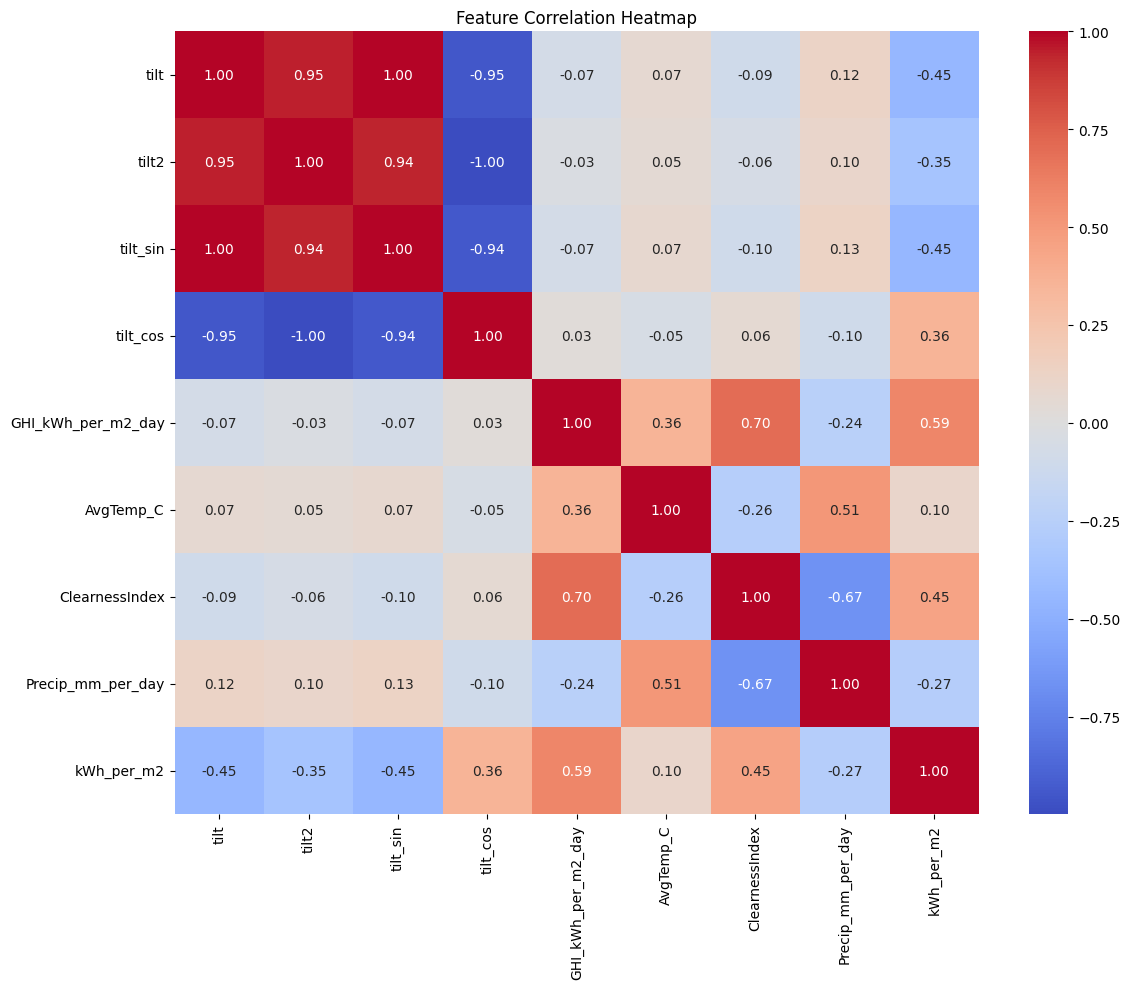

In [31]:
# corelation heatmap
import seaborn as sns
import matplotlib.pyplot as plt 
# filter numeric columns only
numeric_cols = df.select_dtypes(include=[np.number]).columns
df = df[numeric_cols]
# compute correlation matrix
corr = df.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.tight_layout()

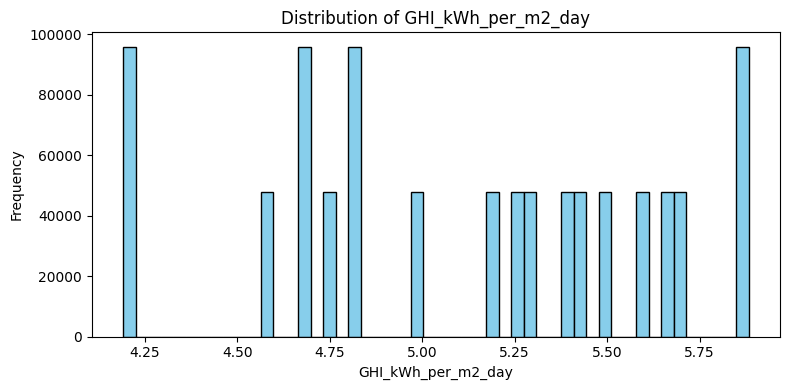

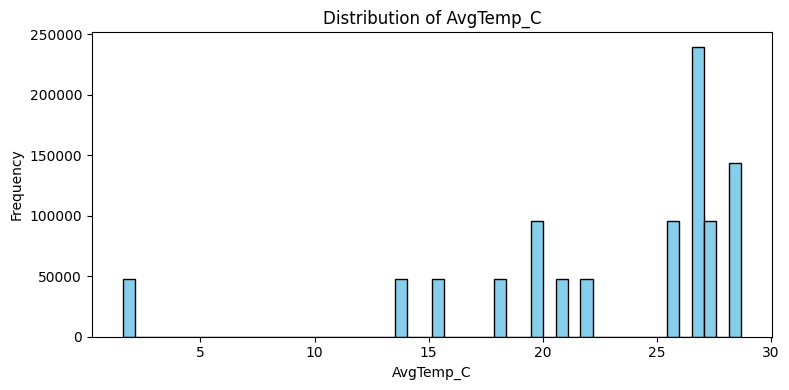

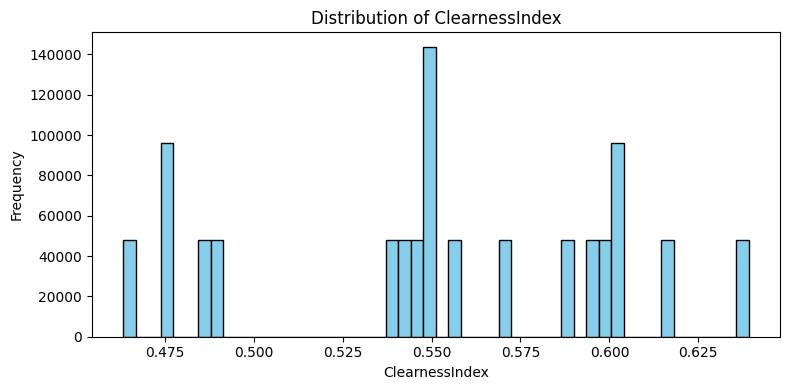

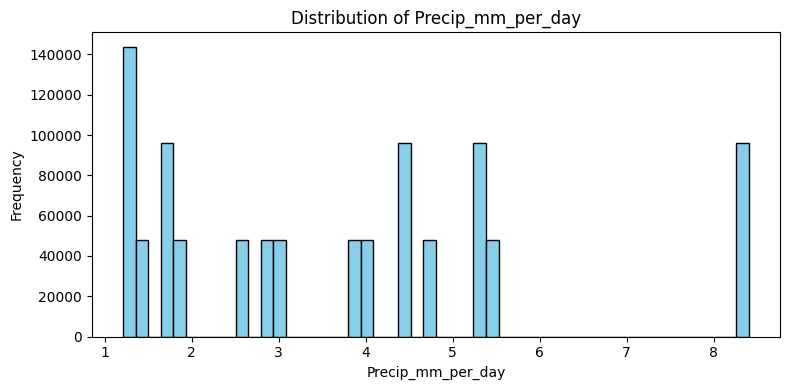

In [32]:
# a quick eda with weather features
import pandas as pd
from pathlib import Path
DATA = Path("C:/Users/User/Desktop/ML/Project/solar-potential-analysis-github-setup/New_approach/dataset/cleaned_datasets/top20_balanced_sample.parquet")
df = pd.read_parquet(DATA)
weather_cols = ["GHI_kWh_per_m2_day","AvgTemp_C","ClearnessIndex","Precip_mm_per_day"]
# plot histograms for weather features
import matplotlib.pyplot as plt
for col in weather_cols:
    plt.figure(figsize=(8,4))
    plt.hist(df[col].dropna(), bins=50, color='skyblue', edgecolor='black')
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()